# **机器学习公开课 - 数据竞赛制胜法宝：集成学习**
## Day 3：XGBoost与模型融合

> 节选自《2021机器学习实战》正课<br>
> 作者：@菜菜TsaiTsai<br>
> 版本号：2021/11/03 V1<br>

## 0 课程规划

欢迎来到为期三天的《数据竞赛制胜法宝：集成学习》公开课。在这门课程中，我将用三天时间带你熟悉3个经典集成算法、并了解简单的模型融合方式。基于开课之前的投票结果，这门课程将偏向代码实践、而不是理论详解的方向，当你完成这门课程时，你将能够自由应用GBDT、XGB和LGBM三种算法进行建模和参数调整。如果想系统地学习集成算法的具体理论，则可以向客服小可爱咨询正课《2021机器学习实战》。

**DAY 1：集成学习与梯度提升树GBDT**

**DAY 2：改进提升树：LGBM**

**DAY 3：XGBoost与模型融合**

为掌握这门课程，你需要先掌握：
- Python基础 >> 《九天老师的Python基础》<br>https://www.bilibili.com/video/BV1U54y1W7jw?spm_id_from=333.999.0.0

- 基础机器学习算法（决策树的建树过程）与随机森林 >> 《2021机器学习实战公开课》<br>https://www.bilibili.com/video/BV1f3411r7EP?share_source=copy_web

In [4]:
import sklearn
import matplotlib as mlp
import numpy as np
import pandas as pd
import re

In [2]:
for package in [sklearn,mlp,np,pd]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.3.2
numpy 1.19.2
pandas 1.1.3


In [ ]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

## 一 XGBoost

XGBoost全称Extreme Gradient Boosting，译为极致提升树或极限提升树，它是卡耐基梅隆大学的助理教授Tianqi Chen在GBDT基础上改进后的算法，也是所提升集成算法中最成功的算法之一。

与GBDT一样，XGBoost遵循boosting算法的基本训练流程：**依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，并以最小化$L(x,y)$为目标影响下一个弱评估器$f(x)_t$的构建**，因此xgboost很自然的也会有学习率、损失函数、树的数量这些参数。不同于GBDT的是，XGBoost在提升三要素：损失函数$L(x,y)$、弱评估器$f(x)$以及集成规则上都做出了许多改变，这些改变使得XGBoost比GBDT运算更快、精度更高、并且更不容易过拟合，在许多时候，我们都发现XGBoost的预测结果比GBDT更好。

|年份|算法/理论|成就/改进|
|----|----|-----|
|2000|GBDT<br>在ADB基础上改进|更新损失函数$L(x,y)$，在数学流程上推广到任意可微函数<br>放弃调整数据分布、放弃弱分类器权重<br>自适应地调整**后续弱评估器拟合的目标**|
|2014|XGBoost<br>在GBDT基础上改进|更新损失函数$L(x,y)$，在损失函数中加入正则项<br>改进弱评估器$f(x)$生长规则，自适应地**调整后续弱评估器的结构**<br>改进拟合中的数学过程，提升拟合精度<br>首次在工程上实现了决策树分枝的并行，提升运算速度<br>支持GPU加速|

陈天奇创造了XGBoost之后，很快和一群机器学习爱好者建立了专门调用XGBoost库，名为xgboost。xgboost是一个独立的，开源的，专门提供梯度提升树以及XGBoost算法应用的算法库。这个库需要我们单独下载和安装：

In [ ]:
#!pip install xgboost #安装xgboost库
#!pip install --upgrade xgboost #更新xgboost库

In [3]:
import xgboost as xgb

In [4]:
xgb.__version__

'1.5.0'

我们有两种方式可以来使用我们的xgboost库。第一种方式，是直接使用xgboost库自己的建模流程。

![](https://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%2011%20XGBoost/xgb%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B.PNG)

其中最核心的，是DMatrix这个读取数据的类，以及train()这个用于训练的函数。与sklearn把所有的参数都写在类中的方式不同，xgboost库中必须先使用字典设定参数集，再使用train来将参数及输入，然后进行训练。

*class* `xgboost.DMatrix`(data, label=None, *, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None, group=None, qid=None, label_lower_bound=None, label_upper_bound=None, feature_weights=None, enable_categorical=False)

*function* `xgboost.train`(params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

幸运的是，上面这些参数我们不需要都掌握。先来看看最简单的，使用以上类调用xgboost进行训练的基本流程。

In [5]:
data = pd.read_csv(r"I:\公开课sample_data2.csv",index_col=0)

data.head()

X = data.iloc[:,:-1]
y = data.iloc[:,-1] #标签是订单金额

In [6]:
X.shape

(131282, 11)

In [7]:
#XGBoost模块的三步走：DMatrix定义数据，定义需要输入的参数params，直接调用训练
#不难发现，XGBoost不需要实例化，train函数包揽了实例化和训练的功能

In [8]:
data = xgb.DMatrix(X,y)
params = {"seed":1412} #随机数种子
reg = xgb.train(params,data) #默认使用10棵树进行学习

In [9]:
y_pred = reg.predict(data)

In [10]:
#对回归类算法，xgboost的默认评估指标是RMSE
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False) #RMSE

361.8051599869066

*function* `xgboost.cv`(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric=None)

In [13]:
#在xgboost中使用交叉验证
result = xgb.cv(params,data,nfold=5,seed=1412)

result是每一轮迭代后模型输出的训练测试结果，因此最后一行就是集成算法最终输出的结果：

In [14]:
result.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
5,418.997058,1.578860,420.278253,1.575909
6,396.460645,2.071016,397.958106,3.030848
7,380.941608,2.586478,382.422388,3.362756
8,368.946167,2.629663,370.638001,4.949211
9,357.610193,3.130375,359.885644,4.550248


In [15]:
4.550248**2

20.704756861504

最终测试集上输出的RMSE结果是359.8856，方差为20.70，是个相当大的数字。

|算法(10棵树)|RMSE|方差|
|----|----|----|
|GBDT|581.081|1.6194|
|LGBM|444.568|1.8189|
|XGB|359.885|20.704|

在都使用10棵树的前提下，GBDT计算时间略长，且交叉验证的RMSE最大，LGBM计算快，但RMSE的水平居中，XGB的RMSE最低，但模型方差过大，极其不稳定。这种不稳定可能与XGB参数设置中的随机性有较大的关系，XGB设计了大量抗过拟合的手段，因此在树的数量非常少时会展现出高度不稳定的状态。我们之后可以试着增加树的数量，来对比三个算法在更多树数量下产出的结果。

或者，我们也可以选择第二种方法，使用xgboost库中的sklearn的API。这是说，我们可以调用如下的类，并用我们sklearn当中惯例的实例化，fit和predict的流程来运行XGB，并且也可以调用属性比如coef_等等。当然，这是我们回归的类，我们也有用于分类，用于排序的类。他们与回归的类非常相似，因此了解一个类即可。

*class* `xgboost.XGBRegressor`(n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs)

由于不像xgboost原生类一样，可以将需要的参数和功能分配到不同的函数里去，xgboost的sklearn API中的参数异常地多，总共有33个。众多的参数向我们展示了xgboost巨大的灵活性，但学习成本也的确很高。

In [47]:
str_ = "n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs"

In [48]:
len(str_.split(","))

33

我们来尝试调用一下这个类：

In [49]:
from xgboost import XGBRegressor

In [50]:
xgb2 = XGBRegressor(n_estimators=10,random_state=1412)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [51]:
result_xgb2 = CSV(xgb2,X,y,cv=cv,scoring="neg_mean_squared_error")

In [52]:
(abs(result_xgb2)**0.5).mean()

359.8855803855457

In [53]:
(abs(result_xgb2)**0.5).var()

20.704800080225752

在最新版本的xgboost当中，sklearnAPI的RMSE值和方差与原生代码都一模一样，不过大部分时候的经验告诉我们，xgboost原生代码精度更高、速度更快。当然，真实在使用的时候你也可以进行尝试，选择在当下的数据上效果更好的代码。

在xgboost原生训练函数与xgboost的sklearnAPI虽然使用相同的算法，但参数却不太一致。部分复杂的功能只能够在xgboost原生代码中来实现：

|参数相关的流程|原生库参数|skleanAPI参数|
|----|----|--|
|损失函数|**objective**, lambda ,alpha|objective, reg_alpha, reg_lambda|
|集成规则|**eta**, base_score, eval_metric, <br>subsample, sampling_method, colsample_bytree,<br> colsample_bylevel, colsample_bynode|learning_rate, base_score, eval_metric, <br>subsample, colsample_bytree, <br>colsample_bylevel, colsample_bynode|
|弱评估器|**num_boost_round**,<br>booster, tree_method,<br>sketch_eps, updater, grow_policy|n_estimators, booster, tree_method|
|弱评估器<br>（抗过拟合）|num_feature, max_depth, <br>gamma, min_child_weight, max_delta_step, <br>max_leaves, max_bin|max_depth, gamma, <br>min_child_weight, max_delta_step|
|训练流程<br>（结果监控）|**verbosity**|verbosity|
|训练流程<br>（提前停止）|early_stopping_rounds|early_stopping_rounds|
|训练流程<br>（增量学习）||warm_start|
|随机性控制|seed|random_state|
|其他流程|**missing**, scale_pos_weight, <br>predictor, **num_parallel_tree**|n_jobs, scale_pos_weight,<br>num_parallel_tree,enable_categorical,<br>importance_type|

不难发现，xgboost中大量的参数都是关于具体的集成规则及弱评估器建立的，其中一些参数我们绝不会在xgboost之外的算法上见到，比如tree_method。tree_method决定了弱分类器被建立的规则，其中包括按照XGBoost原论文建立的gbtree，按照估计树论文建立的approx tree，依照LGBM论文改进的hist tree，还有专门用于gpu加速的建树方法。这些方法已经脱离了原本的C4.5和CATR树的建树规则，都是依赖于**结构分数**而不是不纯度衡量指标进行分枝。关于建树的细节以及相关参数的具体应用我们会在《2021机器学习实战》课程当中详细讲到。

- **objective, eta, num_boost_round**

xgboost是基于GBDT建立，因此其基本流程中的参数也与GBDT非常类似，因此xgboost当中必填的三个参数也与GBDT一致：**目标函数、学习率和树的棵树**。

其中**objective**指的是目标函数（也就是损失函数+模型复杂度），模型复杂度又由树的结构$\gamma T$与正则项组成。

<center>$Obj = \sum_{i=1}^ml(y_i,\hat{y_i}) + \sum_{k=1}^K\Omega(f_k)$</center><br>

<center>$\Omega(f_k) = \gamma T + 正则项(Regularization)$</center>

实际在填写objective参数时，我们填写的是目标函数中损失函数$l$的名称，不包括正则项，该参数的默认值为平方损失。在objective当中我们有数十种选择，常见的有：

- 用于回归
> - reg:squarederror：平方损失
> - reg:squaredlogerror：平方对数损失

- 用于分类
> - binary:logistic：二分类交叉熵损失，输出概率
> - binary:logitraw：二分类交叉熵损失，输出执行sigmoid变化之前的值
> - multi:softmax：多分类交叉熵损失，输出具体的类别
> - multi:softprob：多分类交叉熵损失，输出每个样本每个类别下的概率

还有众多用于排序算法、计数算法的损失函数。xgboost几乎适用于所有可微的损失函数，一般来说xgboost会根据输入的数据自动指定objective，但为了明确算法的类型（分类/回归/排序），我们一般还是会把objective参数写上。

如果要决定完整的目标函数，则可以使用参数**lambda**和**alpha**，其中lambda是L2正则项的系数，alpha是L1正则项的系数，默认lambda为1，alpha为0，所以xgboost默认的正则化方法是L2正则化。

**num_boost_round**就相当于GBDT当中的n_estimators，实际上我们在xgboost的sklearnAPI中也是把这个参数写作n_estimators。在原生代码下，num_boost_round的默认值为10，但是在sklearnAPI下，该默认值为100。相同含义的参数在不同API下默认值不同的情况在xgboost当中非常常见，因此我们需要注意观察每个参数的默认值。

**eta**就是学习率，在sklearnAPI当中是learning_rate，在原生代码中默认值为0.3。

objective, num_boost_round以及eta的使用方法都与lgb当中的使用方法一模一样。如果我们希望，我们可以使用学习曲线来进行调参：

In [40]:
cv_train = []
cv_test = []
for eta in np.linspace(0.1,0.5,10):
    params = {"objective":"reg:squarederror"
              ,"eta":eta
              ,"seed":1412} #随机数种子
    result = xgb.cv(params,data,num_boost_round=100,nfold=5,seed=1412)
    cv_test.append(result.iloc[-1,-2])
    cv_train.append(result.iloc[-1,0])
    print("completed {}".format(eta))

completed 0.1
completed 0.14444444444444446
completed 0.18888888888888888
completed 0.23333333333333334
completed 0.2777777777777778
completed 0.32222222222222224
completed 0.3666666666666667
completed 0.4111111111111111
completed 0.4555555555555556
completed 0.5


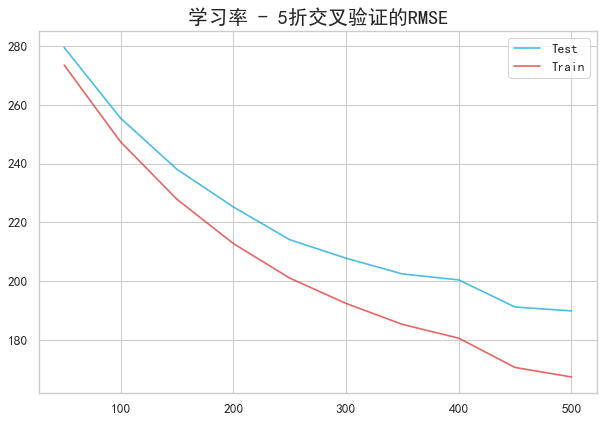

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei'] #让jupyter中的图画上的中文都显示出来
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(9,6),dpi=80)
plt.plot(range(50,550,50),cv_test,color="#01a2d9",alpha=0.7,label="Test")
plt.plot(range(50,550,50),cv_train,color="#dc2624",alpha=0.7,label="Train")
plt.legend()
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("学习率 - 5折交叉验证的RMSE",fontsize=18)
plt.show()

- **verbosity**

由于xgboost的训练流程一般较长，因此xgboost在早期就提供了自动监控训练流程的参数。在最早的版本中该参数为silent，后来经过更新变成了今天的verbosity。然而，经过改进之后的verbosity更倾向于帮助我们打印建树相关的信息，而不像原来的silent一样帮助我们展示训练过程中的模型评估信息，因此verbosity现在不那么实用了。

我们可以在verbosity中设置数字[0,1,2,3]，参数默认值为1。

- 0：不打印任何内容
- 1：表示如果有警告，请打印警告
- 2：请打印建树的全部信息
- 3：我正在debug，请帮我打印更多的信息。

我们来看看具体的打印内容：

In [38]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":1 #如果有警告就打印警告，没有警惕则不打印任何内容
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

In [39]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":2 #打印进度
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nod

In [40]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":3
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[16:47:57] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/gbm/gbtree.cc:155: Using tree method: 2
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: 

- **missing**与**num_parallel_tree**

xgboost作为独立于sklearn的机器学习算法库，一直有着两个美誉：

> 1. xgboost可以自动处理缺失值，无需进行填补
> 2. xgboost可以并行建树，因此计算速度很快

这两个美誉分别指向我们的参数missing与num_parallel_tree，但这两个参数的实际应用方式与大家的想象有些不同。先来说简单的参数num_parallel_tree。在num_parallel_tree当中，我们可以输入一个数字，表示允许并行建立的树的数量。当我们不输入任何数字的时候，xgboost库会按照算力进行最大程度的并行。**然而，这种并行功能对论文中描述的xgboost无效，只能被用于使用xgboost库建立随机森林的时候**。随机森林作为bagging算法，天生就可以并行建立树，因此能够并行建树的并不是xgboost，而是xgboost库下的随机森林。

当然，xgboost算法本身也的确实现了速度的提升。虽然根据boosting的原理，树必须是一棵一棵建立的，**但对不同特征的分枝却是可以并行的**。xgboost在原理上实现并行分枝，因此建立每一棵树的速度都比其他集成算法更快。不过，这种并行是xgboost默认的，没有任何的参数可以帮助我们控制这种行为。

接下来来看参数missing，虽然xgboost处理缺失值的能力被传得神乎其神，但实际上，**只要代码允许，任意树模型都可以忍受特征有缺失的数据**。虽然这有些反常识，但树模型的预测结果与特征值本身关系并不大，因为所有叶子上的输出都是依赖于标签进行推导的，特征["A","A","A","B","B"]和特征[1,1,1,2,2]在决策树看来是完全一样的内容。这也是决策树对数据预处理的要求如此之低的关键原因。

来看一个基本的以MSE为criterion进行分枝的例子：

In [47]:
#假设现在对一个特征进行分枝，数据中总共有5个样本
#y_true是5个样本的真实标签
#y_parent是现在的父节点上输出的预测标签，分枝一定是从一个父节点分成两个子节点，因此父节点上的输出一定要存在
#假设父节点就是决策树的根节点
y_true = np.array([[0],[5],[30],[10],[10]])
y_parent = np.array([[11],[11],[11],[11],[11]])

**<center>平方误差的不纯度下降量</center>**
<center>$父节点平方误差 - (左子节点平方误差 + 右子节点平方误差)_{加权}$</center><br>
<center>$\sum_p{(y_i - \hat{y_i})^2} - \left( \frac{w_l}{w_l+w_r} * \sum_l{(y_i - \hat{y_i})^2} + \frac{w_r}{w_l+w_r} * \sum_r{(y_i - \hat{y_i})^2} \right)$<br></center><br>

In [48]:
SamplesInParent = 5
for i in range(1,SamplesInParent):
    #打印分枝的可能性
    print("left:{},right:{}".format(i,SamplesInParent-i))
    
    #计算左右叶子节点上的样本量，也就是不纯度下降量公式中的权重
    w_left = i
    w_right = SamplesInParent-i
    
    #父节点上的总MSE
    parentMSE = ((y_true - y_parent)**2).sum()
    
    #计算左右叶子节点上的输出：对回归树来说，就是当前叶子节点上所有样本的真实标签的均值
    y_left = y_true[:i].mean()
    y_right = y_true[i:].mean()
    
    #计算左右叶子节点上的MSE
    leftsum = ((y_true[:i] - y_left)**2).sum()
    rightsum = ((y_true[i:] - y_right)**2).sum()
    
    #加权求和左右叶子节点上的MSE
    childMSE = leftsum*w_left/SamplesInParent + rightsum*w_right/SamplesInParent
    
    print("\t improvement in MSE:{:.3f}".format(parentMSE - childMSE))

left:1,right:4
	 improvement in MSE:225.000
left:2,right:3
	 improvement in MSE:355.000
left:3,right:2
	 improvement in MSE:210.000
left:4,right:1
	 improvement in MSE:105.000


依据MSE下降的结果，父节点子节点MSE差异最大的分枝是左2右3。你发现了，**这个分枝过程当中，完全没有用到任何的特征值**。所以处理缺失值是决策树天生的能力，只不过在sklearn当中，数据可靠性检验的时候不允许有缺失，因此任何算法都无法处理缺失值。在xgboost当中就没有这么严格的可靠性检验，即便数据的特征缺失，还是可以根据标签继续进行分枝计算的。对于xgboost具体是如何处理缺失值的，原作者团队都有一些争议。在xgboost官网上，明确说到有缺失的样本会被删除(removed)，但陈天齐和其他团队成员曾在社交网络上评论说，xgboost不会删除带有缺失值的样本，而会直接根据训练中标签的分枝结果，将带有缺失的样本分到相应的叶子节点上。

根据官网的说明，参数missing可以控制一部分缺失值的处理，**在missing当中我们可以输入任何字符串或数字，xgboost会将数据中任意特征量等于missing参数值的样本删除**。这是说，当我们让missing=1时，数据中任意特征值为1的样本都会被删除，所以missing这个参数的默认值是np.nan。

XGBoost其实是一个非常复杂的算法，为了能够在直播中快速实现参数的调用，我们对于参数本身和许多原理都讲解得很浅显。在《2021机器学习实战》正课当中，我们将详细地剖析XGBoost的各项原理与参数具体应用方法。

- **四大集成模型调参总览**

★★★ 一定要调整，调整之后有很大的概率可以提升模型表现<br>
★★ 可以调整，有机会提升模型表现<br>
★ 只能微调，模型表现几乎不会有太大变化<br>
--- 完全无法无法调整<br>

|算法|样本均衡|树数量&学习率|过拟合<br>(弱学习器&损失函数)|过拟合<br>(随机性)|过拟合<br>(提前停止)||
|---|---|---|---|---|---|---|
|GBDT|---|★★★<br>n_estimators<br>learning_rate|★<br>max_depth<br>min_samples_split<br> min_samples_leaf|★★★<br>max_features<br>subsample|★★<br>n_iter_no_change|
|XGB|★<br>scale_postive_weight=1|★★★<br>num_boost_round<br>eta|★<br>max_depth<br>lambda<br>alpha|★★★<br>num_feature<br>subsample<br>★★<br>colsample_bytree<br> colsample_bylevel<br> colsample_bynode|★★<br>early_stopping_round|
|LGBM|★<br>scale_postive_weight=1|★★★<br>num_boost_round<br>eta|★★★<br>max_depth<br>lambda_l1<br> lambda_l2<br>★★<br>min_data_in_leaf<br>max_delta_step|★★★<br>feature_fraction<br>bagging_fraction<br>|★★<br>early_stopping_round|
|RF|★★★<br>class_weight=None|★★★<br>n_estimators<br>learning_rate|★★★<br>max_depth<br>★<br>min_samples_split<br>min_samples_leaf|★★★<br>subsample<br>★★<br>max_features='auto'|---|

### 二、模型融合

模型融合是当代机器学习集成方法中最为关键的提效手段之一。通过融合多个强学习器，我们可以大幅修正单一算法在偏差和方差方面的问题：当单一算法在一个样本上的偏差较高时（MSE高、准确率低），我们可以通过其他算法在该样本上的预测结果来修正这种高偏差；当单一算法在不同数据上的方差较大时，我们可以借助其他稳定的模型来消除单一算法的大方差带来的影响。在boosting思想诞生之前，模型融合的许多经典方法就已经诞生了，甚至可以说bagging装袋法也是融合思想的结晶之一。现在，使用比较广泛的融合方式有以下几种：

- **均值法Averaging**
> - 将所有算法的结果普通平均、加权平均
> - 我们可以从数学上证明，当各个强学习器相互独立时，强学习期平均后的误差一定是小于单一学习器的误差的
> - 需要注意，加权平均与普通平均的效果不相上下，有时候加权平均还会加重过拟合，因此我们更偏好于使用普通平均
- **投票法Voting**
> - 包含绝对多数投票（例如：50%投票）、相对多数投票（硬投票法）、加权投票法、软投票法等各类投票方法，仅仅适用于分类数据。<br>
> - 绝对多数投票要求样本的其中一个类别至少占比50%以上，如果没有占比50%以上的类别，则拒绝预测，输出控制<br>
> - 相对多数投票就是最简单的少数服从多数<br>
> - 软投票则是根据各强学习期输出的概率之和少数服从多数
- **堆叠法Stacking**
> - 建立一个元学习器与一个/多个个体学习器，将原始数据分为train与test。使用train训练个体学习器，并使用个体学习器(们)在train上的某种输出/中间结果，作为元学习器的训练数据，最终让元学习器在test上输出结果。
> - 如果只有一个个体学习器，则会执行交叉验证得出多组输出结果来作为元学习器的训练数据
> - 最著名的stacking法应用是逻辑回归+GBDT，其中逻辑回归是个体学习器，GBDT是元学习器，GBDT使用逻辑回归的输出概率作为训练数据。也可以使用决策树作为个体学习器，元学习器可以使用决策树中的叶子索引、树结构、重要性指标或者输出结果作为训练数据。
- **混合法Blending**
> - Blending是一种特殊的Stacking
> - 建立一个元学习器与一个/多个个体学习器，将原始数据分为train，validation与test，使用train训练个体学习器，并使用个体学习器(们)在validation上的某种输出/中间结果，作为元学习器的训练数据，最终让元学习器在test上输出结果。

在sklearn中，我们可以轻松地使用下面的类来实现平均、投票与堆叠法。截止到2021年11月7日，sklearn还不支持blending方法。

*class* `sklearn.ensemble.VotingRegressor`(estimators, *, weights=None, n_jobs=None, verbose=False)<br>

*class* `sklearn.ensemble.VotingClassifier`(estimators, *, voting='hard', weights=None, n_jobs=None, flatten_transform=True, verbose=False)<br>

回归类投票法就是平均法，我们可以使用weights参数来输入权重，当指定权重时，就是加权平均法。VotingClassifier就是分类算法使用的投票法，我们可以使用voting参数调节硬投票与软投票，weights来指定权重。

*class* `sklearn.ensemble.StackingClassifier`(estimators, final_estimator=None, *, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)<br>

*class* `sklearn.ensemble.StackingRegressor`(estimators, final_estimator=None, *, cv=None, n_jobs=None, passthrough=False, verbose=0)<br>

Stacking可以用于分类和回归，只要元学习器的输出是相应的分类/回归输出即可。

对于我们当下的问题和数据，我们可以尝试使用VotingRegressor对GBDT、XGB和LGBM进行融合。**但需要注意的是，sklearn中的融合工具只支持sklearn中的评估器，不支持xgb、lgbm的原生代码**。因此，如果我们想要对原生代码下的模型进行融合，必须自己手写融合过程。

考虑到模型融合的逻辑并不复杂，手写融合过程并不是一个很有挑战性的工作。不过，我们也可以选择直接使用xgboost与lgbm的sklearn API来建立模型，这样就可以将模型打包在sklearn的融合工具中进行融合了。

- 建立三个评估器（sklearn API），并分别查看交叉验证下的结果

In [62]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_val_score as CSV
from sklearn.model_selection import KFold
#import lightgbm as lgb
#import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from time import time

In [63]:
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

> **GBR**

In [159]:
gbr = GBR(n_estimators=100,random_state=1412)

In [160]:
start = time()
result_gbr = CSV(gbr,X,y,cv=cv,scoring="neg_mean_squared_error")
print(time()-start)

43.603492736816406


In [161]:
(abs(result_gbr)**0.5).mean()

396.96524429050487

In [162]:
(abs(result_gbr)**0.5).var()

11.218087827112537

> **LGBM**

In [163]:
lgbm = LGBMRegressor(n_estimators=100,random_state=1412,force_col_wise=True,metric="rmse")

In [164]:
start = time()
result_lgb = CSV(lgbm,X,y,cv=cv,scoring="neg_mean_squared_error")
print(time()-start)

1.158822774887085


In [165]:
(abs(result_lgb)**0.5).mean()

278.1041099194505

In [166]:
(abs(result_lgb)**0.5).var()

9.546768918499128

> **XGBoost**

In [167]:
xgb_reg = XGBRegressor(n_estimators=100,random_state=1412)

In [168]:
start = time()
result_xgb = CSV(xgb_reg,X,y,cv=cv,scoring="neg_mean_squared_error")
print(time()-start)

14.942680597305298


In [169]:
(abs(result_xgb)**0.5).mean()

210.87126054622726

In [170]:
(abs(result_xgb)**0.5).var()

9.870540394847437

|算法(100棵树)|RMSE|方差|
|----|----|----|
|GBDT|396.965|11.2180|
|LGBM|278.377|9.5467|
|XGB|210.871|9.8704|

- 使用最简单的平均法进行融合

In [172]:
from sklearn.ensemble import VotingRegressor

#需要以元组的列表方式来构建estimators
gbr = GBR(n_estimators=100,random_state=1412)
lgbm = LGBMRegressor(n_estimators=100,random_state=1412,force_col_wise=True,metric="rmse")
xgb_reg = XGBRegressor(n_estimators=100,random_state=1412)

In [173]:
estimators = [("GBR",gbr),("LGBM",lgbm),("XGB",xgb_reg)]
mix = VotingRegressor(estimators,verbose=True)
cvresult = CSV(mix,X,y,cv=cv,scoring="neg_mean_squared_error")

[Voting] ...................... (1 of 3) Processing GBR, total=   8.9s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.2s
[Voting] ...................... (3 of 3) Processing XGB, total=   3.0s
[Voting] ...................... (1 of 3) Processing GBR, total=   8.7s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.2s
[Voting] ...................... (3 of 3) Processing XGB, total=   2.9s
[Voting] ...................... (1 of 3) Processing GBR, total=   8.4s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.2s
[Voting] ...................... (3 of 3) Processing XGB, total=   3.1s
[Voting] ...................... (1 of 3) Processing GBR, total=   8.8s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.2s
[Voting] ...................... (3 of 3) Processing XGB, total=   2.8s
[Voting] ...................... (1 of 3) Processing GBR, total=   8.8s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.2s
[Votin

In [174]:
(abs(cvresult)**0.5).mean()

276.5967460613563

In [175]:
(abs(cvresult)**0.5).var()

9.56818862007965

你发现了吗？模型融合的结果还没有XGB单独的结果好，这是融合模型经常会出现的陷阱，也是大多数人掌握了代码，却没有真正懂得使用融合模型的关键原因。平均融合的效果好于单一评估器的效果是有前提的：

- 评估器是精调之后的强学习器
- 被融合的评估器在交叉验证上的分数差异不大
- 评估器与评估器之间是相互独立的

在满足了这三个条件之后，融合模型的效果才可能好于单一集成算法。其中第一个条件可以通过精调来完成，第二个条件需要看模型能够达到的水平，如果存在RMSE过高或者准确率过低的单一模型，我们则需要在融合的时候放弃该模型。第三个条件则需要通过集成算法当中的随机性来控制：使用随机性参数，令评估器之间的差异越大，评估器之间就越相互独立。

我们来看看具体的操作：

In [177]:
gbr = GBR(n_estimators=300 #增加n_estimators，增加模型的学习能力
          ,learning_rate=0.5 #加速迭代，调大学习率
          ,max_features=0.6 #控制每次建树时能够使用的特征量，以此来让GBDT中树的差异变大，这可能会加大交叉验证结果的方差
          ,random_state=1412)

In [178]:
start = time()
result_gbr = CSV(gbr,X,y,cv=cv,scoring="neg_mean_squared_error")
print(time()-start)

74.82734513282776


In [179]:
(abs(result_gbr)**0.5).mean()

243.57883448638546

In [180]:
(abs(result_gbr)**0.5).var()

12.566177233188109

> **LGBM**

In [184]:
lgbm = LGBMRegressor(n_estimators=200,learning_rate=0.5 #同样提升树的数量和学习率
                     ,random_state=1412,force_col_wise=True
                     ,colsample_bytree=0.6 #每次建树时随机抽取特征进行建树
                     ,metric="rmse")

In [185]:
start = time()
result_lgb = CSV(lgbm,X,y,cv=cv,scoring="neg_mean_squared_error")
print(time()-start)

1.7853901386260986


In [186]:
(abs(result_lgb)**0.5).mean()

209.79153535802192

In [187]:
(abs(result_lgb)**0.5).var()

12.571422101880497

> **XGBoost**

In [193]:
xgb_reg = XGBRegressor(n_estimators=100,learning_rate=0.5,colsample_bytree=0.6,random_state=1412)

In [194]:
start = time()
result_xgb = CSV(xgb_reg,X,y,cv=cv,scoring="neg_mean_squared_error")
print(time()-start)

10.649511098861694


In [195]:
(abs(result_xgb)**0.5).mean()

200.84104520043624

In [196]:
(abs(result_xgb)**0.5).var()

6.58760884445049

|算法(精调+加入随机性之后)|RMSE|方差|
|----|----|----|
|GBDT|243.578|12.5661|
|LGBM|209.791|12.5714|
|XGB|200.841|6.587|

会发现，现在GBDT与剩下两个算法的差异太大，把GBDT也加入融合或许不是一个很好的选择。我们可以分别融合一下三个模型以及两个模型，看一下最终的结果：

In [ ]:
#3个模型

In [199]:
estimators = [("GBDT",gbr),("LGBM",lgbm),("XGB",xgb_reg)]
mix = VotingRegressor(estimators,verbose=True)

In [201]:
cvresult = CSV(mix,X,y,cv=cv,scoring="neg_mean_squared_error")

[Voting] ..................... (1 of 3) Processing GBDT, total=  14.7s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.3s
[Voting] ...................... (3 of 3) Processing XGB, total=   2.0s
[Voting] ..................... (1 of 3) Processing GBDT, total=  15.0s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.3s
[Voting] ...................... (3 of 3) Processing XGB, total=   2.0s
[Voting] ..................... (1 of 3) Processing GBDT, total=  15.0s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.3s
[Voting] ...................... (3 of 3) Processing XGB, total=   2.5s
[Voting] ..................... (1 of 3) Processing GBDT, total=  15.5s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.3s
[Voting] ...................... (3 of 3) Processing XGB, total=   2.2s
[Voting] ..................... (1 of 3) Processing GBDT, total=  15.4s
[Voting] ..................... (2 of 3) Processing LGBM, total=   0.4s
[Votin

In [202]:
(abs(cvresult)**0.5).mean()

200.93284635947438

In [203]:
(abs(cvresult)**0.5).var()

4.660882490269849

In [ ]:
#2个模型

In [204]:
estimators = [("LGBM",lgbm),("XGB",xgb_reg)]
mix = VotingRegressor(estimators,verbose=True)
cvresult = CSV(mix,X,y,cv=cv,scoring="neg_mean_squared_error")

[Voting] ..................... (1 of 2) Processing LGBM, total=   0.6s
[Voting] ...................... (2 of 2) Processing XGB, total=   2.5s
[Voting] ..................... (1 of 2) Processing LGBM, total=   0.4s
[Voting] ...................... (2 of 2) Processing XGB, total=   2.6s
[Voting] ..................... (1 of 2) Processing LGBM, total=   0.4s
[Voting] ...................... (2 of 2) Processing XGB, total=   2.5s
[Voting] ..................... (1 of 2) Processing LGBM, total=   0.4s
[Voting] ...................... (2 of 2) Processing XGB, total=   2.3s
[Voting] ..................... (1 of 2) Processing LGBM, total=   0.4s
[Voting] ...................... (2 of 2) Processing XGB, total=   2.2s


In [205]:
(abs(cvresult)**0.5).mean()

192.4772815119236

In [206]:
(abs(cvresult)**0.5).var()

5.257916642365961